In [1]:
%matplotlib inline

import os
import pyxdf
import numpy as np
import mne
import matplotlib.pyplot as plt

### Settings

In [2]:
# Files
subject = 'P00J'
session = 1
task = 'MI-hands'
lslDir = r'C:\Users\leungj\Documents\CurrentStudy'

# LSL Stream
eeg_stream_name = 'mindset_EXG'
markers_stream_name = 'Mindset_Unity'

# Experiment parameters
rest_duration = 5
task_duration = 5

In [3]:
# Find files
xdf_files = []
for root, dir, files in os.walk(lslDir):
    if subject in root:
        for file in files:
            if (subject in file) and (('ses-S' + str(session).zfill(3)) in file) and (task in file):
                matchingFile = os.path.join(root, file)
                print(matchingFile)
                xdf_files.append(matchingFile)

C:\Users\leungj\Documents\CurrentStudy\sub-P00J\ses-S001\eeg\sub-P00J_ses-S001_task-MI-hands_run-001_eeg.xdf
C:\Users\leungj\Documents\CurrentStudy\sub-P00J\ses-S001\eeg\sub-P00J_ses-S001_task-MI-hands_run-002_eeg.xdf
C:\Users\leungj\Documents\CurrentStudy\sub-P00J\ses-S001\eeg\sub-P00J_ses-S001_task-MI-hands_run-003_eeg.xdf
C:\Users\leungj\Documents\CurrentStudy\sub-P00J\ses-S001\eeg\sub-P00J_ses-S001_task-MI-hands_run-004_eeg.xdf
C:\Users\leungj\Documents\CurrentStudy\sub-P00J\ses-S001\eeg\sub-P00J_ses-S001_task-MI-hands_run-005_eeg.xdf


In [4]:
# Parse streams
eeg_stream, marker_stream = [], []

print('Parsing streams')
for xdf_file in xdf_files:
    streams, header = pyxdf.load_xdf(xdf_file)
    for i in range(len(streams)):
        if streams[i]['info']['name'][0] == eeg_stream_name:
            eeg_stream.append(streams[i])
        elif streams[i]['info']['name'][0] == markers_stream_name:
            marker_stream.append(streams[i])
del streams, header

Parsing streams


In [5]:
# Extract EEG data
print("Extracting EEG data")

ch_names = []
for i in range(len(eeg_stream[0]['info']['desc'][0]['channels'][0]['channel'])):
    ch_names.append(eeg_stream[0]['info']['desc'][0]['channels'][0]['channel'][i]['label'][0])
print('Channels: ', ch_names)

sfreq = float(eeg_stream[0]['info']['nominal_srate'][0])
print('Sampling frequency: ', sfreq)

Extracting EEG data
Channels:  ['FP1', 'FP2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2', 'F7', 'F8', 'F3', 'F4', 'T7', 'T8', 'P3', 'P4']
Sampling frequency:  125.0


In [14]:
# Create MNE info object
eeg_info = mne.create_info(ch_names, sfreq, ch_types='eeg')


current_eeg_stream = eeg_stream[0]
# Create MNE Raw object
eeg_data = np.transpose(eeg_stream[0]['time_series'])
# eeg_data = eeg_data / 1e6
print(eeg_data.shape)
eeg_raw = mne.io.RawArray(eeg_data, eeg_info)

# Add annotations
onset, duration, description = [], [], []
# print(marker_stream[0]['time_series'])

for i in range(len(marker_stream[0]['time_series'])):
    if ('rest' in marker_stream[0]['time_series'][i][0]):
        onset.append(marker_stream[0]['time_stamps'][i] - eeg_stream[0]['time_stamps'][0])
        duration.append(rest_duration)
        description.append(marker_stream[0]['time_series'][i][0])
    elif ('task' in marker_stream[0]['time_series'][i][0]):
        onset.append(marker_stream[0]['time_stamps'][i] - eeg_stream[0]['time_stamps'][0])
        duration.append(task_duration)
        description.append(marker_stream[0]['time_series'][i][0].replace('task_', '').replace('-','/'))
annotations = mne.Annotations(onset, duration, description)
eeg_raw = eeg_raw.set_annotations(annotations)

(16, 19512)
Creating RawArray with float64 data, n_channels=16, n_times=19512
    Range : 0 ... 19511 =      0.000 ...   156.088 secs
Ready.


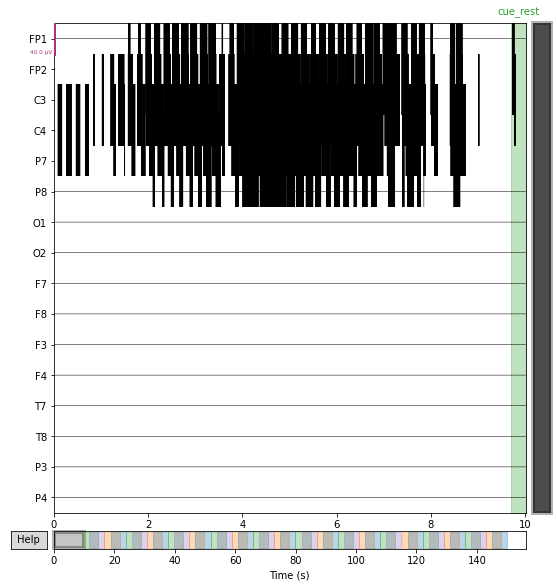

In [15]:
# plot eeg data
fig = eeg_raw.plot(title='Raw Data', n_channels=len(ch_names), show=True)

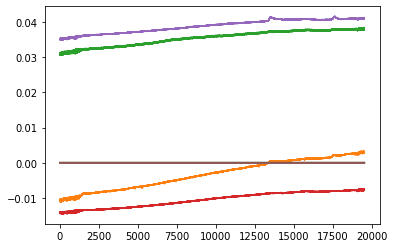

In [24]:
plt.plot(eeg_stream[0]['time_series'] / 1e6)